In [74]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

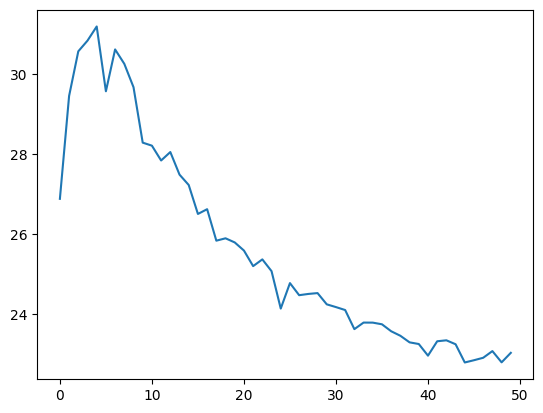

31.19089363790611
23.02320274316711


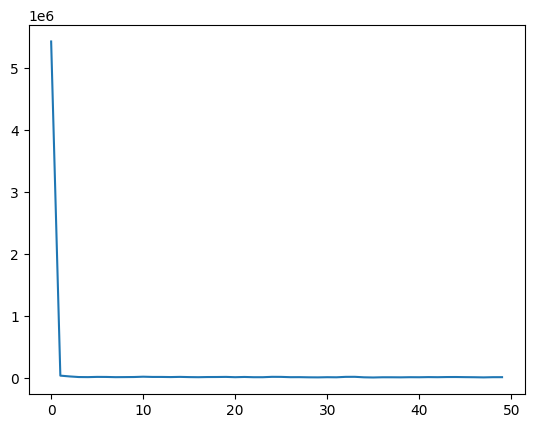

(array([4]),)


In [91]:
import sys
kaggle_path_prefix = "../input/admm-tgv/TGV数据库/"
sys.path.append(kaggle_path_prefix)


from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv


import os
import cv2
import numpy as np
import random
from models import *

import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from utils.denoising_utils import *
from utils.sr_utils2 import *
from utils.utils import *
# from numpy.random import randn

import skimage

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1
PLOT = True
sigma = 20 #25
sigma_ = sigma/255.


name = 'hill_GT.png'

fname = f"../input/admm-tgv/TGV数据库/data2/denoising/%s"%(name)


# Add synthetic noise
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil) 
  
# pay attention!
if img_np.shape[0]==2:
  img_np_temp = np.zeros((3,img_np.shape[1], img_np.shape[2]))
  img_np_temp[0,:,:] = img_np[0,:,:]  
  img_np_temp[1,:,:] = img_np[0,:,:]
  img_np_temp[2,:,:] = img_np[0,:,:]
  img_np = img_np_temp
if img_np.shape[0]==4:
  img_np = img_np[:-1,:,:]
  
  
###########################画图，关闭坐标轴
def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid
    
    Args:
        images_np: list of images, each image is np.array of size 3xHxW of 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure 
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"
    
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)
    
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    
    
    plt.xticks([])  #关闭坐标刻度
    plt.yticks([])  #关闭坐标刻度
    plt.axis('off')  #关闭坐标轴
    
    plt.show()
    
    return grid


def get_noisy_image(img_np, sigma_):
    """Adds Gaussian noise to an image.
    
    Args: 
        img_np: image, np.array with values from 0 to 1
        sigma: std of the noise
    """
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    #torch.normal(img_noisy_pil, img_noisy_np)
    

    img_noisy_np = np.clip(img_np + sigma_*np.random.normal(scale=1.0, size=img_np.shape), 0, 1).astype(np.float32)
    
#     img_noisy_np = np.clip(img_np + sigma_*np.random.random(size=img_np.shape), 0, 1).astype(np.float32) 
      
#     img_noisy_np=np.uint8(img_noisy_np*255)

    img_noisy_pil = np_to_pil(img_noisy_np)

    return img_noisy_pil, img_noisy_np

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)


if PLOT:
    plot_image_grid([img_np, img_noisy_np], 4, 5);

print(img_np.shape)


INPUT = 'noise' 
pad = 'reflection' 
OPT_OVER = 'net' 

# reg_noise_std = 1./30.  

show_every = 4 #2

num_iter = 50
input_depth = 3     #3
figsize = 10 
    
    
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=5,
              upsample_mode='bilinear').type(dtype)
    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()



# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)



size = img_np.shape
h = size[-2]
w = size[-1]
Dh_psf = np.array([ [0, 0, 0], [1, -1, 0], [0, 0, 0]])
Dv_psf = np.array([ [0, 1, 0], [0, -1, 0], [0, 0, 0]])
Id_psf = np.array([[1]])

Id_DFT = torch.from_numpy(psf2otf(Id_psf, [h,w])).cuda()
Dh_DFT = torch.from_numpy(psf2otf(Dh_psf, [h,w])).cuda()
Dv_DFT = torch.from_numpy(psf2otf(Dv_psf, [h,w])).cuda()

DhT_DFT = torch.conj(Dh_DFT)
DvT_DFT = torch.conj(Dv_DFT)


LR = 1e-3
optimizer = torch.optim.Adam(net.parameters(), lr=LR)


#定义散度
def div(zx, zy):
    [zxx, zxy] = D(zx, Dh_DFT, Dv_DFT)
    [zyx, zyy] = D(zy, Dh_DFT, Dv_DFT)
    div = zxx + zyy
    return div


## net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0


img_noisy_torch = np_to_torch(img_noisy_np).type(dtype) 
u   = 0 * img_noisy_torch
v1  = 0 * img_noisy_torch
v2  = 0 * img_noisy_torch
t  = 0 * img_noisy_torch
q11  = 0 * img_noisy_torch
q12  = 0 * img_noisy_torch
q21  = 0 * img_noisy_torch
q22  = 0 * img_noisy_torch
p1  = 0 * img_noisy_torch
p2  = 0 * img_noisy_torch

tao  = 0.003
beta =20
w1 = 0.005
gama = 0.02
sigma1 = 0.03
alpha1 = 10
alpha2 =1
lambda0 =20
rou  =60




num_iter1=10
num_iter2=1
                                                                                                              
inner_iterations = 50

loss_values = []
fun_values = []
psnr_values = []
running_loss=0

[v11, v12] = D(v1, Dh_DFT, Dv_DFT)
[v21, v22] = D(v2, Dh_DFT, Dv_DFT)
for i in range(num_iter):
    
    if inner_iterations>1:
        optimizer = torch.optim.Adam(net.parameters(), lr=LR)

    for j in range(inner_iterations):
        optimizer.zero_grad()

    # First problem
        out = net(net_input)
        total_loss = (lambda0/2)  * norm2_loss(img_noisy_torch - out)
        total_loss += ( rou/2) * norm2_loss(out - u +  t ).detach()
        total_loss.backward()
        optimizer.step()

    running_loss = total_loss.item()
    loss_values.append(running_loss)

    # out = net(net_input)


    #  second problem: 更新u
    
    for k in range(num_iter1):
        
        u = ((u + tao * div(p1, p2) + tao * rou *(out + t )) / (1 + rou * tao)).detach().clone()
        [u1, u2] = D(u, Dh_DFT, Dv_DFT)#计算梯度
        
        # 更新 p
        
        #计算 梯度u - v
        b1 = u1-v1
        b2 = u2-v2
        mochang1 = torch.sqrt(torch.pow(b1, 2) + torch.pow(b2, 2) )
        #计算ε（v）

        b11 = v11
        b12 = 1/2 * (v12 + v21)
        b21 = 1/2 * (v12 + v21)
        b22 = v22
        mochang2 = torch.sqrt(torch.pow(b11, 2) + torch.pow(b12, 2) + torch.pow(b21, 2) + torch.pow(b22, 2))
        fenmu = beta+alpha1*mochang1+alpha2*mochang2
        cigema = ((beta+1)*alpha1 )/ fenmu
        
        a1 = p1 + gama * (u1-v1)
        a2 = p2 + gama * (u2-v2)
        fanshu =  torch.sqrt(torch.pow(a1, 2) + torch.pow(a2, 2) )
        mm = torch.clamp( fanshu / cigema, min=1)
        p1 = (a1 / mm).detach().clone()
        p2 = (a2 / mm).detach().clone()
        
     # 更新 v
    for m in range(num_iter2):
        v1 = (v1 + w1*(p1+div(q11, q12))).detach().clone()
        v2 = (v2 + w1*(p2+div(q21, q22))).detach().clone()

    #  epsilon(v)
    
        [v11, v12] = D(v1, Dh_DFT, Dv_DFT)
        [v21, v22] = D(v2, Dh_DFT, Dv_DFT)
            
    # 更新 q
        # [u1, u2] = D(u, Dh_DFT, Dv_DFT)
        c1 = u1-v1
        c2 = u2-v2
        mochang3 = torch.sqrt(torch.pow(c1, 2) + torch.pow(c2, 2) )
        c11 = v11
        c12 = 1/2 * (v12 + v21)
        c21 = 1/2 * (v12 + v21)
        c22 = v22
        mochang4 = torch.sqrt(torch.pow(c11, 2) + torch.pow(c12, 2) + torch.pow(c21, 2) + torch.pow(c22, 2))
        fenmu1 = beta+alpha1*mochang3+alpha2*mochang4
        yita = ((beta+1)*alpha2) / fenmu1
        a11 = q11 + sigma1 * v11 
        a12 = q12 + sigma1 * 1/2 * (v12 + v21)
        a21 = q21 + sigma1 * 1/2 * (v12 + v21)
        a22 = q22 + sigma1 * v22 

        fanshu =  torch.sqrt(torch.pow(a11, 2) + torch.pow(a12, 2) + torch.pow(a21, 2) + torch.pow(a22, 2))
        mm = torch.clamp( fanshu / yita, min=1)
        q11 = (a11 / mm).detach().clone()
        q12 = (a12 / mm).detach().clone()
        q21 = (a21 / mm).detach().clone()
        q22 = (a22 / mm).detach().clone()

    # t
    t = (t -u + out).detach().clone() 
        
    psrn_noisy = compare_psnr(img_noisy_np, img_np)   ###噪声图psnr
    psrn_gt    = compare_psnr(img_np[0,:,:], out[0,:,:].detach().cpu().numpy()[0]) 
      
    psnr_values.append(psrn_gt)
    if psrn_gt >=  max(psnr_values):
        out_psnrmax = out
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=5)



out_np = torch_to_np(net(net_input))
psnr_gt = compare_psnr(img_np[0,:,:], out_np[0,:,:])
print(psrn_noisy)
print(psrn_gt)
plot_image_grid([np.clip(out_np, 0, 1), img_np,img_noisy_np], factor=18);


out_psnrmax_np = torch_to_np(out_psnrmax)  ####找出psnr最大时的图
plot_image_grid([img_noisy_np,img_np,np.clip(out_psnrmax_np, 0, 1)], factor=15);
psnr_gt    = compare_psnr(img_np[0,:,:], out_psnrmax_np[0,:,:]) 
print(psnr_gt)


#######  psnr   ssim 
###计算psnr

psnr=compare_psnr(img_np[0,:,:],out_psnrmax_np[0,:,:] )
print(psnr)

########      计算ssim
ss = compare_ssim(img_np[0,:,:],out_psnrmax_np[0,:,:],data_range=1.0)

# ss = compare_ssim(img_np,img_noisy_np)
print(ss)
out_psnrmax_np = torch_to_np(out_psnrmax)
plot_image_grid([img_noisy_np,img_np,np.clip(out_psnrmax_np, 0, 1)], factor=15);
psnr_gt    = compare_psnr(img_np[0,:,:], out_psnrmax_np[0,:,:]) 
print(psnr_gt)


plot_image_grid([np.clip(out_psnrmax_np, 0, 1)], factor=4);
plot_image_grid([img_noisy_np], factor=4);


plt.plot(range(len(psnr_values)), psnr_values)
plt.show()
print(np.max(psnr_values))
print(psnr_values[-1])

plt.plot(range(len(loss_values)), loss_values)
plt.show()

re=np.where(psnr_values==np.max(psnr_values))
print(re)